# Xarray to ML

Xarray is a great package for multi-dimmensional datasets. But there are no standard way to go from xarray to ML packages. 

In [1]:
import xarray as xr
import numpy as np

import itertools

import matplotlib.pyplot as plt

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

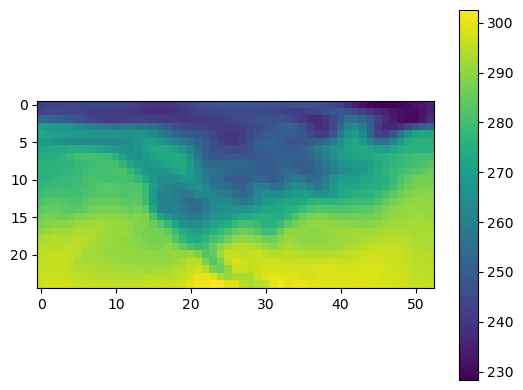

In [3]:
plt.imshow(ds.air.isel(time=1))
plt.colorbar()

## Let's add one more variabe:

This is more realistic for many of our ML workflows, where we will use mutiple inputs to predict a feature or number.

In [4]:
ds['air2'] = ds['air'] * np.random.normal(size=ds['air'].shape)
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
    air2     (time, lat, lon) float64 168.2 207.9 -89.49 ... 20.91 -86.17 -245.1
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

## Dataset Exploration:

Air is the one variable for this dataset.

In [5]:
print('air data type:', type(ds.air.data))
print('air data shape:', np.shape(ds.air.data))

air data type: <class 'numpy.ndarray'>
air data shape: (2920, 25, 53)


2920 timesteps, by 25 lat steps, and 53 lon steps.

In [6]:
num_of_timesteps = np.size(ds.time)
num_of_timesteps

2920

If we wanted to create a timestep offset, to predict into the futre by n amount. Note: for this notebook, we are considering going from numpy arrays and back to be enough for this proof of concept. No ML (or science!) will be done in this notebook.

In [7]:
timesteps = 12 #offset

x_ts = range(0, num_of_timesteps-timesteps)
y_ts = range(timesteps, num_of_timesteps)

np.shape(x_ts) == np.shape(y_ts)

True

# Method 1:

Lambda's to iteratre through the list

In [8]:
x_a = list(map(lambda t1: ds.air.isel(time=t1).data.ravel(), x_ts))
x_b = list(map(lambda t1: ds.air.isel(time=t1).data.ravel(), x_ts))

merged_x = list(itertools.chain(*x_a)), list(itertools.chain(*x_b))
print('merged_x type:', type(merged_x))
print('merged_x shape:', np.shape(merged_x))

merged_x type: <class 'tuple'>
merged_x shape: (2, 3853100)


In our make belive world, we only care about predicting one variable?

In [9]:
y_b = list(map(lambda t2: ds.air.isel(time=t2).data.ravel(), y_ts))
merged_y = list(itertools.chain(*y_b))

In [10]:
x = np.asarray(merged_x)
y = np.asarray(merged_y)

In [11]:
np.shape(y), np.shape(x)

((3853100,), (2, 3853100))

## Method 2:

In [12]:
x_ = list(map(lambda t1: ds.to_array().transpose('time', 'lon', 'lat', 'variable').values[t1,:,:,:].reshape(1325, 2), x_ts))

merged_x = list(itertools.chain(*x_))

x_2 = np.asarray(merged_x)

print('shape of x_2', np.shape(x_2))

shape of x_2 (3853100, 2)


I missed something in the re-shape .... 

In [13]:
x.T == x_2

array([[ True, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [ True, False]])

Hat tip to Charlie Becker (NCAR) for this tip

## If you need to re-shape the outputs of ML models:

In [14]:
output = y+4*np.random.rand(len(y))
output

array([251.00481377, 249.60784647, 249.64870767, ..., 299.85426633,
       298.3470004 , 298.11507076])

Some bookkeeping 

In [15]:
len(y_ts)*25*53 == len(output)

True

In [16]:
reshaped_output = output.reshape(len(y_ts), 25, 53)
np.shape(reshaped_output)

(2908, 25, 53)

In [17]:
reshaped_output

array([[[251.00481377, 249.60784647, 249.64870767, ..., 241.08120058,
         243.37225991, 246.21042742],
        [250.01955203, 249.75934555, 249.89669366, ..., 238.44897977,
         240.57279445, 242.95465944],
        [253.64157807, 257.74776512, 255.22348603, ..., 241.52940279,
         246.51285885, 246.41281812],
        ...,
        [300.3002482 , 296.23312429, 297.56630681, ..., 296.58567359,
         295.77966471, 296.5378346 ],
        [299.52629082, 299.21848286, 297.83185891, ..., 296.07438737,
         297.10024977, 298.24076674],
        [298.5374615 , 301.36069756, 299.33379469, ..., 298.48701649,
         298.7124896 , 301.17662124]],

       [[251.13309113, 252.48335261, 253.46650507, ..., 241.51505473,
         239.79627452, 243.53324812],
        [251.891807  , 250.25653635, 251.57354874, ..., 240.18567642,
         241.8339896 , 243.82045186],
        [254.38686703, 254.73848264, 258.00848095, ..., 248.73213237,
         248.35695871, 248.95815609],
        ...,


In [18]:
new_xarray = xr.DataArray(data = reshaped_output,
                          dims=['time','lat','lon'],
                          coords=dict(
                              lon=(ds.lon),
                              lat=(ds.lat),
                              time=y_ts)
                          )

In [19]:
new_xarray

<xarray.DataArray (time: 2908, lat: 25, lon: 53)>
array([[[251.00481377, 249.60784647, 249.64870767, ..., 241.08120058,
         243.37225991, 246.21042742],
        [250.01955203, 249.75934555, 249.89669366, ..., 238.44897977,
         240.57279445, 242.95465944],
        [253.64157807, 257.74776512, 255.22348603, ..., 241.52940279,
         246.51285885, 246.41281812],
        ...,
        [300.3002482 , 296.23312429, 297.56630681, ..., 296.58567359,
         295.77966471, 296.5378346 ],
        [299.52629082, 299.21848286, 297.83185891, ..., 296.07438737,
         297.10024977, 298.24076674],
        [298.5374615 , 301.36069756, 299.33379469, ..., 298.48701649,
         298.7124896 , 301.17662124]],

       [[251.13309113, 252.48335261, 253.46650507, ..., 241.51505473,
         239.79627452, 243.53324812],
        [251.891807  , 250.25653635, 251.57354874, ..., 240.18567642,
         241.8339896 , 243.82045186],
        [254.38686703, 254.73848264, 258.00848095, ..., 248.73213237,
         248.35695871, 248.95815609],
...
        [297.49979962, 297.41367783, 298.90853865, ..., 298.98763319,
         297.89376443, 298.00436357],
        [297.19906317, 300.02920845, 301.4782347 , ..., 296.39955204,
         297.59853847, 297.83581844],
        [299.78372678, 300.66155086, 299.6927459 , ..., 297.77195704,
         297.59209081, 298.56394011]],

       [[245.70834442, 247.16809891, 246.9816186 , ..., 241.74291626,
         244.65588666, 244.68291666],
        [251.595259  , 251.07265348, 251.85337039, ..., 240.20851135,
         242.92919256, 243.99909307],
        [264.58169888, 263.84991486, 263.95617947, ..., 240.09157307,
         244.50044637, 247.44879918],
        ...,
        [295.62511484, 296.63354977, 298.14036567, ..., 298.72249206,
         296.99225428, 297.04528299],
        [299.84680848, 296.97269695, 299.14872295, ..., 298.7986307 ,
         296.73262926, 298.55620201],
        [299.321627  , 298.7849618 , 299.68145182, ..., 299.85426633,
         298.3470004 , 298.11507076]]])
Coordinates:
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * time     (time) int64 12 13 14 15 16 17 18 ... 2914 2915 2916 2917 2918 2919

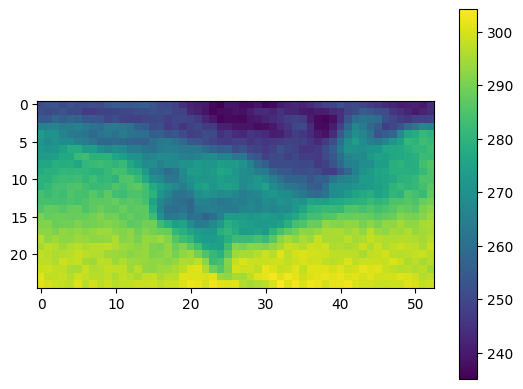

In [20]:
plt.imshow(new_xarray.isel(time=1))
plt.colorbar()